# Fine-Tuning Techniques from Scratch

**Problem:** Pre-trained LLMs are general-purpose. We need them to excel at specific tasks.

**Our Goal:** Adapt a model to classify sentiment with limited resources.

We'll compare techniques, starting expensive and moving to efficient methods.

## Why Not RAG?

**RAG is for knowledge.** It retrieves facts from documents when the LLM doesn't know something.

**Fine-tuning is for behavior.** It teaches the model how to respond-style, format, reasoning patterns.

**Our task (sentiment classification):** The model knows what "positive" and "negative" mean. It doesn't need external documents. It needs to learn the *behavior* of classifying text consistently.

**When to use what:**
- Missing knowledge? → RAG
- Need specific output format/style/task? → Fine-tuning
- Both? → Fine-tuned model + RAG

## Setup

In [1]:
# Install required packages
%pip install transformers datasets peft bitsandbytes accelerate torch -q


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
import gc

# Detect best available device
if torch.cuda.is_available():

    device = "cuda"
    print(f"Using device: {device}")

elif torch.backends.mps.is_available():

    device = "mps"    
else:
    device = "cpu"

/Users/akhilchintalapati/Documents/Code/Week1/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. The Task: Sentiment Analysis

Toy dataset to demonstrate fine-tuning clearly.

In [3]:
# Small training dataset
train_data = {
    "text": [
        "This product is amazing! Best purchase ever.",
        "Terrible quality, broke after one day.",
        "Works perfectly, very satisfied with my order.",
        "Waste of money, would not recommend.",
        "Exceeded my expectations, fantastic!",
        "Disappointed, does not work as advertised.",
        "Great value for the price, I love it.",
        "Poor customer service and faulty product.",
        "Highly recommend, excellent quality.",
        "Regret buying this, complete failure."
    ],
    "label": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1=positive, 0=negative
}

# Test dataset
test_data = {
    "text": [
        "Absolutely wonderful experience!",
        "Never buying from them again.",
        "Perfect for my needs.",
        "Broken on arrival."
    ],
    "label": [1, 0, 1, 0]
}

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nExample: {train_dataset[0]}")

Training samples: 10
Test samples: 4

Example: {'text': 'This product is amazing! Best purchase ever.', 'label': 1}


## 2. Baseline: Full Fine-Tuning

**Approach:** Update all model parameters.

**Problem:** Memory intensive, slow, requires lots of data.

In [4]:
# Use tiny model for demonstration
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Check model size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Memory footprint: {total_params * 4 / 1e9:.2f} GB (fp32)")

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 2414.93it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Total parameters: 66,955,010
Trainable parameters: 66,955,010
Memory footprint: 0.27 GB (fp32)


In [5]:
# Tokenize data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results_full",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="no",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized
)

print("Starting full fine-tuning...")
trainer.train()
print("\nFull fine-tuning complete!")

Map: 100%|██████████| 4/4 [00:00<00:00, 1497.70 examples/s]

Starting full fine-tuning...



/Users/akhilchintalapati/Documents/Code/Week1/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss
1,No log,0.677435
2,0.703454,0.657558
3,0.703454,0.643645



Full fine-tuning complete!


In [6]:
# Test predictions
def predict_sentiment(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return "Positive" if prediction == 1 else "Negative"

test_texts = [
    "I love this so much!",
    "Horrible experience, very upset.",
    "Best thing I ever bought."
]

print("Full Fine-Tuning Predictions:")
for text in test_texts:
    pred = predict_sentiment(text, model, tokenizer)
    print(f"  '{text}' -> {pred}")

# Clean up
del model, trainer
gc.collect()

if torch.cuda.is_available():    

    torch.cuda.empty_cache()

elif torch.backends.mps.is_available():

    torch.mps.empty_cache()

Full Fine-Tuning Predictions:
  'I love this so much!' -> Positive
  'Horrible experience, very upset.' -> Positive
  'Best thing I ever bought.' -> Positive


## 3. LoRA: Low-Rank Adaptation

**Problem:** Full fine-tuning updates millions of parameters.

**Solution:** Only train small adapter matrices. Massive memory savings.

In [7]:
# Load fresh model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  # Rank of adapter matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"],  # Which layers to adapt
)

# Wrap model with LoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# See the difference
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"\nTrainable: {trainable:,} ({100 * trainable / total:.2f}%)")
print(f"Memory saving: ~{100 * (1 - trainable/total):.1f}%")

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 2532.23it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925

Trainable: 739,586 (1.09%)
Memory saving: ~98.9%


In [8]:
# Train with LoRA
training_args = TrainingArguments(
    output_dir="./results_lora",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="no",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized
)

print("Starting LoRA fine-tuning...")
trainer.train()
print("\nLoRA fine-tuning complete!")

Starting LoRA fine-tuning...


Epoch,Training Loss,Validation Loss
1,No log,0.704258
2,0.717407,0.699430
3,0.717407,0.697743



LoRA fine-tuning complete!


In [9]:
# Test LoRA predictions
print("LoRA Predictions:")
for text in test_texts:
    pred = predict_sentiment(text, model, tokenizer)
    print(f"  '{text}' -> {pred}")

# Clean up
del model, trainer
gc.collect()
if torch.cuda.is_available():

    torch.cuda.empty_cache()    
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

LoRA Predictions:
  'I love this so much!' -> Positive
  'Horrible experience, very upset.' -> Positive
  'Best thing I ever bought.' -> Positive


## 4. Comparison: Architecture Visualization

Show what's actually different between techniques.

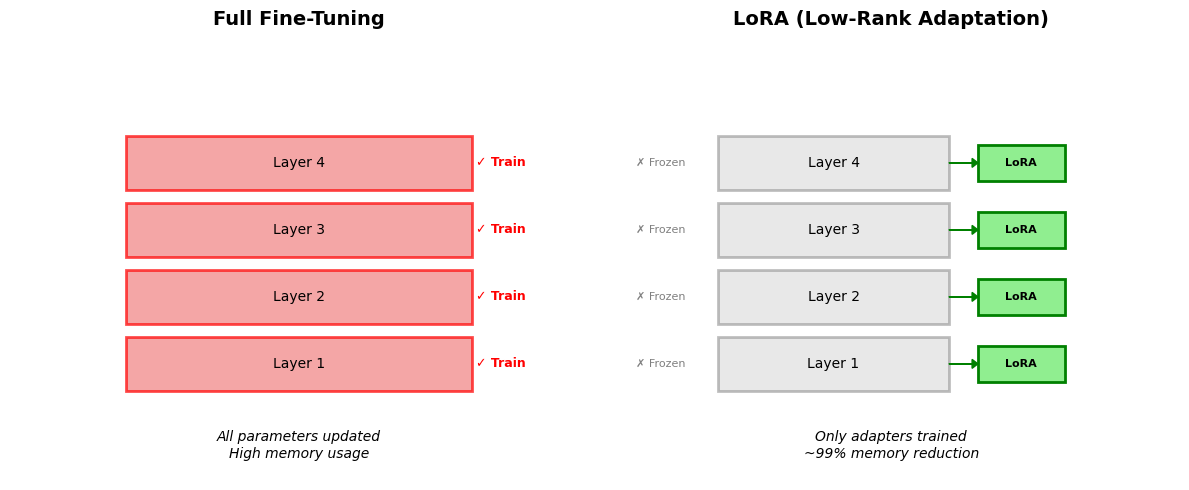

## 5. QLoRA: Quantized LoRA

**Problem:** Even LoRA needs base model in memory.

**Solution:** Quantize base model to 4-bit, further reducing memory.

In [10]:
from transformers import BitsAndBytesConfig

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Load model in 4-bit
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto"
)

# Prepare for k-bit training
model = prepare_model_for_kbit_training(model)

# Apply LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

print("\nQLoRA: 4-bit base model + LoRA adapters")
print("Memory usage: ~75% less than regular LoRA")

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 169.72it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925

QLoRA: 4-bit base model + LoRA adapters
Memory usage: ~75% less than regular LoRA


## 6. Technique Comparison Table

When to use what?

| Technique | Trainable Params | Memory | Training Speed | Performance | Use When |
|-----------|------------------|--------|----------------|-------------|----------|
| Full Fine-Tuning | 100% | High | Slow | Best | Lots of data & compute |
| LoRA | ~1% | Medium | Fast | Very Good | Limited resources, good data |
| QLoRA | ~1% | Low | Fast | Very Good | Very limited GPU memory |
| Prompt Tuning | <0.1% | Very Low | Fastest | Good | Minimal resources |

---

**Recommendation:** Start with LoRA for best balance of efficiency and performance

## 7. Real-World: Fine-Tuning with OpenAI API

For production use cases without managing infrastructure.

In [11]:
import openai
import os
from dotenv import load_dotenv
import json

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# Prepare training data in OpenAI format
training_examples = []
for text, label in zip(train_data["text"], train_data["label"]):
    sentiment = "positive" if label == 1 else "negative"
    training_examples.append({
        "messages": [
            {"role": "system", "content": "You are a sentiment classifier."},
            {"role": "user", "content": f"Classify: {text}"},
            {"role": "assistant", "content": sentiment}
        ]
    })

# Save to JSONL
with open('training_data.jsonl', 'w') as f:
    for example in training_examples:
        f.write(json.dumps(example) + '\n')

Training data prepared for OpenAI fine-tuning
Format: {'messages': [{'role': 'system', 'content': 'You are a sentiment classifier.'}, {'role': 'user', 'content': 'Classify: This product is amazing! Best purchase ever.'}, {'role': 'assistant', 'content': 'positive'}]}

Next steps:
1. Upload file: openai.files.create(file=open('training_data.jsonl'), purpose='fine-tune')
2. Create job: openai.fine_tuning.jobs.create(training_file=file_id, model='gpt-3.5-turbo')
3. Use model: openai.chat.completions.create(model=fine_tuned_model)

## Summary

**Journey:**
1. Full fine-tuning: Expensive baseline
2. LoRA: 99% parameter reduction
3. QLoRA: Added quantization for more savings
4. OpenAI API: Zero infrastructure

**Key Insight:** Modern fine-tuning is about efficiency. LoRA-style methods make fine-tuning accessible.

**Next Steps:**
- Try different LoRA ranks (r=4, 8, 16)
- Experiment with target modules
- Use larger models with QLoRA
- Fine-tune for your specific task